### Objective: Disaster Tweets Kaggle Mini-Project

The goal is to analyze tweets from twitter to determine whether they correspond to an actual disaster. To achive this trainin data is provided that has been catagorized. Goal here is to produce a list based on the test data to see where our models ranks against others on Kaggle.

#### Source 
https://www.kaggle.com/c/nlp-getting-started/overview


In [65]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
from wordcloud import WordCloud
import itertools


#### Use NLTK and Textblob python libraries to preprocess the tweets.
- remove stopwords (common words --> and, I, me)
- tokenize the text (split it into individual words), 
- convert words to lowercase, 
- remove punctuation
- convert each word into a number using word embedding NLTK

In [51]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/umanem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/umanem/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/umanem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/umanem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Load the Training and Test Data in to Keras


In [52]:
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')
print (train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [54]:
### Lets remove punctuation on both train and test data
train_df['text'] = train_df['text'].str.lower().apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
test_df['text'] = test_df['text'].str.lower().apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

#### Lets Visualize the data
Lets determine if we need all the coloums in the data

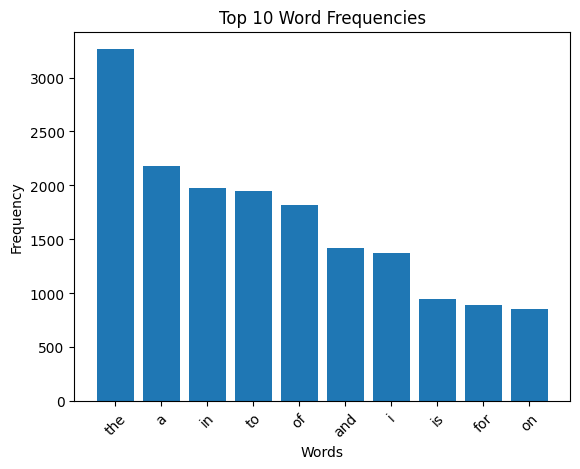

In [55]:
all_words = []
for text in train_df['text']:
    words = text.split()
    all_words.extend(words)
word_counts = Counter(all_words)
word_df = pd.DataFrame(word_counts.most_common(10), columns=['word', 'count'])

### PLOT
plt.bar(word_df['word'], word_df['count'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequencies')
plt.xticks(rotation=45)
plt.show()


### As we can see the token words are domninating the distribution. Lets remove them

In [56]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

train_df['tokens'] = train_df['text'].apply(word_tokenize)
train_df['tokens_no_stop'] = train_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
train_df['stemmed'] = train_df['tokens_no_stop'].apply(lambda x: [stemmer.stem(word) for word in x])
train_df['lemmatized'] = train_df['tokens_no_stop'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

'''
tagged = nltk.pos_tag(tokens)
print(tagged)

text = "This is a great product!"
analysis = TextBlob(text)
print(analysis.sentiment)
'''

'\ntagged = nltk.pos_tag(tokens)\nprint(tagged)\n\ntext = "This is a great product!"\nanalysis = TextBlob(text)\nprint(analysis.sentiment)\n'

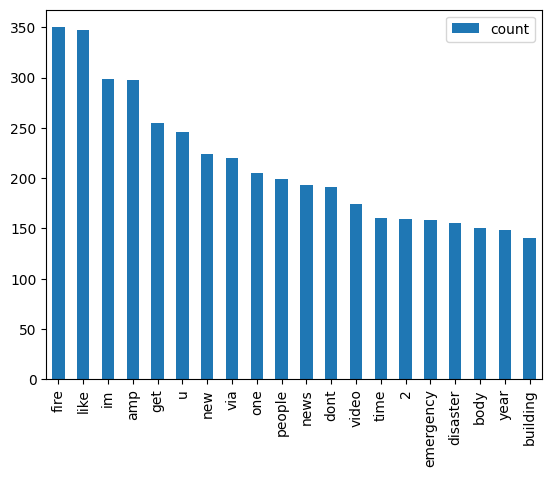

In [57]:
word_list = [word for tokens in train_df['lemmatized'] for word in tokens]
word_counts = Counter(word_list)
df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# Bar chart
df_word_counts_top20 = df_word_counts.sort_values('count', ascending=False).head(20)
df_word_counts_top20.plot(kind='bar')
plt.show()

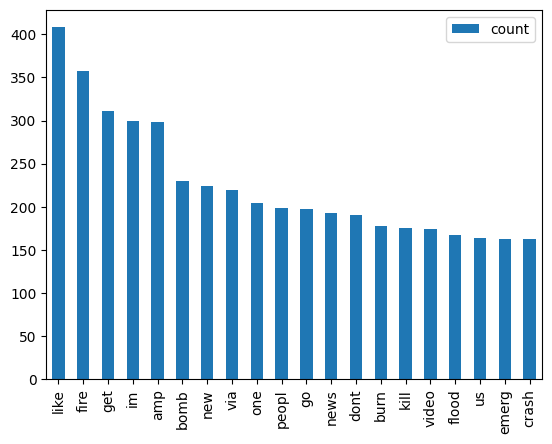

In [58]:
word_list = [word for tokens in train_df['stemmed'] for word in tokens]
word_counts = Counter(word_list)
df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# Bar chart
df_word_counts_top20 = df_word_counts.sort_values('count', ascending=False).head(20)
df_word_counts_top20.plot(kind='bar')
plt.show()

### Quick Analysis
We can see that Lementized and stemmed look about the same for this excerize, so we will stick to Lementaized for the the rest of the analysis.

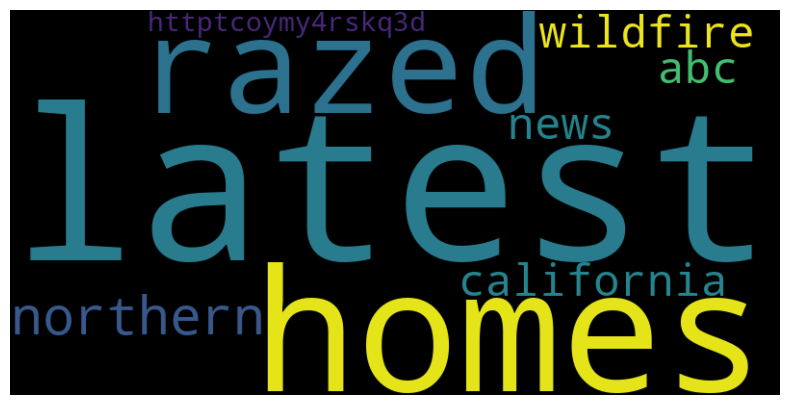

In [59]:
# Word cloud
flat_data = list(itertools.chain.from_iterable(train_df['lemmatized']))
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
### Lets Turn our cleaning process to a fundtion so our pipeline can call it
def tweet_processing(tweet):
    # Generating the list of words in the tweet (hashtags and other punctuations removed)
    tweet_blob = TextBlob(tweet)
    new_tweet = ' '.join(tweet_blob.words)

    tokenized = word_tokenize(new_tweet)
    stop_words = stopwords.words('english')
    stop_words_removed = [word for word in tokenized if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]

    return lemmatized_words
    


### Now lets quntize the Input data for training
we will create word counts based on the lemmatized and use that as a dictonary to create a word mappy list. We will use that as the input for training.

In [64]:
print (train_df['text'])

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610    m194 0104 utc5km s of volcano hawaii httptcozd...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object


In [76]:
X = train_df['text']
y = train_df['target']
kaggle_test = test_df['text']

msg_train, msg_test, label_train, label_test = train_test_split(train_df['text'], train_df['target'], test_size=0.3)

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=tweet_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(msg_train,label_train)

# Evaluate


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function tweet_processing at 0x31eb903a0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [77]:
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))


              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1554
           1       0.61      0.83      0.70       730

    accuracy                           0.78      2284
   macro avg       0.76      0.79      0.76      2284
weighted avg       0.81      0.78      0.78      2284



[[1171  383]
 [ 125  605]]
0.7775831873905429


In [97]:
kaggle_predictions = pipeline.predict(kaggle_test)

test_df['target'] = pd.DataFrame(kaggle_predictions.astype(int))
# Save the DataFrame to a CSV file
test_df.to_csv('nlp-getting-started/test_submission.csv', columns=['id','target'], index=False)
##test_df['target'].to_csv('nlp-getting-started/test_submission.csv', index=True)

### As can be seen this model can be refined further. There are numerous other preprocessing to consder as well as adding feedback to this loop to make it context aware. However given time constraintes the exploration was terminated here.